In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle, time
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp
import numba as nb

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 6

mtype = "erdos_renyi"
n = 500

p = 1./n * 5
G = nx.erdos_renyi_graph(n, p, directed=True)

n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

for u, v in G.edges():
    G[u][v]['weight'] = np.random.rand()

for u, v in G.edges():
    G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=500, G.number_of_edges()=2555
[495, 1, 1, 1, 1, 1]
n_cc = 495, n0 = 500
in  degrees: {0: 0, 1: 23, 2: 38, 3: 61, 4: 89, 5: 85, 6: 73, 7: 54, 8: 33, 9: 18, 10: 12, 11: 8, 12: 1}
out degrees: {0: 0, 1: 11, 2: 39, 3: 57, 4: 103, 5: 103, 6: 65, 7: 52, 8: 29, 9: 20, 10: 8, 11: 5, 12: 2, 13: 1}


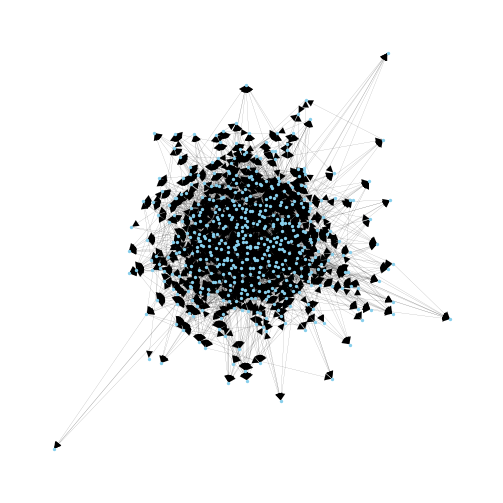

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_strongly_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([0.01071436, 0.07930162, 0.04347132, 0.00386792, 0.00013748]),
 array([ 0.        ,  7.27311371, 14.54622741, 21.81934112, 29.09245482,
        36.36556853]))

In [6]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([0.10185079, 0.0966988 , 0.0937265 , 0.10581385, 0.1022471 ]),
 array([6.06423601e-03, 2.00471695e+00, 4.00336967e+00, 6.00202238e+00,
        8.00067510e+00, 9.99932781e+00]))

In [9]:
info = {} 

In [10]:
fraction_of_nodes = 0.1
pi_rows = np.random.permutation(n)[:int(n * fraction_of_nodes)]
pi_cols = pi_rows #np.random.permutation(n)[:int(n * fraction_of_nodes)]

pi_row_Dist = ldr.sparse_sampled_matrix(pi_rows, Dist, rows=True)
pi_col_Dist_T = ldr.sparse_sampled_matrix(pi_cols, Dist, rows=False)

rDist = np.zeros((n, n))
rDist[pi_rows] = Dist[pi_rows]
assert np.allclose(pi_row_Dist.toarray(), rDist)

cDist = np.zeros((n, n))
cDist[:, pi_cols] = Dist[:, pi_cols]
assert np.allclose(pi_col_Dist_T.T.toarray(), cDist)
print("PASSED")

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

pi_rows_c = np.delete(np.arange(n), pi_rows)
pi_cols_c = np.delete(np.arange(n), pi_cols)

PASSED


In [11]:
for rank in [4, 8, 16, 20]:
    print("\n\nSymmetric fit -> split -> asymmetric fit")
    # get symmetric embedding
    Z_symm, loss, losses = ldr.fast_cc(rank//2, pi_rows=pi_rows, pi_rows_c=pi_rows_c, rDist=(rDist+cDist)/2, symm=True, n_init=5,
                                        max_iter=1000, eps=1e-6, verbose=False, freq=500)
    print(f"\n{rank/2=}, {loss=}")
    # split and fit asymmetric embedding
    l_dar = ldr.construct_node_embedding_graph(Z_symm, adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    Z0 = np.concatenate([Z_symm, Z_symm], axis=0)
    Z, loss, losses = ldr.fast_cc(rank, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, Z0=Z0, n_init=2,
                                    max_iter=1000, eps=1e-6, verbose=False, freq=200)
    print(f"\n{rank=}, {loss=}")
    print(r"$\|x_i-y_j\|_2$")
    l_dar = ldr.construct_xy_node_embedding_graph(Z[:n], Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}


    print("\n\nAsymmetric fit")
    Z, loss, losses = ldr.fast_cc(rank, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, n_init=2, 
                                  max_iter=1000, eps=1e-6, verbose=False, freq=500)
    print(f"\n{rank=}, {loss=}")
    print(r"$\|x_i-y_j\|_2$")
    l_dar = ldr.construct_xy_node_embedding_graph(Z[:n], Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    print(r"$\|x_i-x_j\|_2$")
    l_dar = ldr.construct_node_embedding_graph(Z[:n], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    print(r"$\|y_i-y_j\|_2$")
    l_dar = ldr.construct_node_embedding_graph(Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}



Symmetric fit -> split -> asymmetric fit


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  rho0 = np.dot(r, z)
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  losses[k] = np.sqrt(np.dot(r, r)) / b_norm



rank/2=2.0, loss=13.489108562378494
median_stretch=2334.9%, mean_stretch=3245.6%
%[ratio<2] = 7.00%, %[ratio<1.2] = 4.00%, %[ratio=1.] = 3.00%

rank=4, loss=11.93083092772813
$\|x_i-y_j\|_2$
median_stretch=1493.4%, mean_stretch=2184.0%
%[ratio<2] = 11.30%, %[ratio<1.2] = 6.20%, %[ratio=1.] = 4.80%


Asymmetric fit

rank=4, loss=10.816596631385218
$\|x_i-y_j\|_2$
median_stretch=594.7%, mean_stretch=1176.6%
%[ratio<2] = 22.50%, %[ratio<1.2] = 12.90%, %[ratio=1.] = 8.80%
$\|x_i-x_j\|_2$
median_stretch=2089.4%, mean_stretch=2822.3%
%[ratio<2] = 7.00%, %[ratio<1.2] = 4.90%, %[ratio=1.] = 3.70%
$\|y_i-y_j\|_2$
median_stretch=2257.8%, mean_stretch=3138.5%
%[ratio<2] = 4.80%, %[ratio<1.2] = 3.10%, %[ratio=1.] = 2.90%


Symmetric fit -> split -> asymmetric fit

rank/2=4.0, loss=6.144102872525396
median_stretch=1692.4%, mean_stretch=2599.0%
%[ratio<2] = 10.30%, %[ratio<1.2] = 5.80%, %[ratio=1.] = 4.80%

rank=8, loss=8.736991075087229
$\|x_i-y_j\|_2$
median_stretch=913.3%, mean_stretch=1683.0%
%

In [12]:
mf.rel_diff(Dist, Dist.T)

0.44304893596216954

In [13]:
for rank in [4, 8, 16, 20]:
    print("\n\nSymmetric fit -> split -> asymmetric fit")
    # get symmetric embedding
    Z_symm, loss, losses = ldr.fast_cc(rank//2, pi_rows=pi_rows, pi_rows_c=pi_rows_c, rDist=rDist, symm=True, n_init=5,
                                        max_iter=1000, eps=1e-6, verbose=False, freq=500)
    print(f"\n{rank/2=}, {loss=}")
    # split and fit asymmetric embedding
    l_dar = ldr.construct_node_embedding_graph(Z_symm, adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    Z0 = np.concatenate([Z_symm, Z_symm], axis=0)
    Z, loss, losses = ldr.fast_cc(rank, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, Z0=Z0, n_init=2,
                                    max_iter=1000, eps=1e-6, verbose=False, freq=200)
    print(f"\n{rank=}, {loss=}")
    print(r"$\|x_i-y_j\|_2$")
    l_dar = ldr.construct_xy_node_embedding_graph(Z[:n], Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}


    print("\n\nAsymmetric fit")
    Z, loss, losses = ldr.fast_cc(rank, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, n_init=2, 
                                  max_iter=1000, eps=1e-6, verbose=False, freq=500)
    print(f"\n{rank=}, {loss=}")
    print(r"$\|x_i-y_j\|_2$")
    l_dar = ldr.construct_xy_node_embedding_graph(Z[:n], Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    print(r"$\|x_i-x_j\|_2$")
    l_dar = ldr.construct_node_embedding_graph(Z[:n], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}
    print(r"$\|y_i-y_j\|_2$")
    l_dar = ldr.construct_node_embedding_graph(Z[n:], adjacency_list)
    _ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}



Symmetric fit -> split -> asymmetric fit

rank/2=2.0, loss=20.58251526914149
median_stretch=2054.4%, mean_stretch=3108.5%
%[ratio<2] = 5.70%, %[ratio<1.2] = 3.10%, %[ratio=1.] = 2.20%

rank=4, loss=11.902220956486548
$\|x_i-y_j\|_2$
median_stretch=1352.8%, mean_stretch=2341.0%
%[ratio<2] = 9.00%, %[ratio<1.2] = 5.00%, %[ratio=1.] = 4.00%


Asymmetric fit

rank=4, loss=10.947030081714217
$\|x_i-y_j\|_2$
median_stretch=653.8%, mean_stretch=1153.6%
%[ratio<2] = 19.20%, %[ratio<1.2] = 10.80%, %[ratio=1.] = 7.60%
$\|x_i-x_j\|_2$
median_stretch=2194.5%, mean_stretch=3009.7%
%[ratio<2] = 7.40%, %[ratio<1.2] = 4.20%, %[ratio=1.] = 3.40%
$\|y_i-y_j\|_2$
median_stretch=2146.8%, mean_stretch=3098.8%
%[ratio<2] = 5.80%, %[ratio<1.2] = 3.00%, %[ratio=1.] = 2.30%


Symmetric fit -> split -> asymmetric fit

rank/2=4.0, loss=12.531619870654644
median_stretch=1383.7%, mean_stretch=2049.0%
%[ratio<2] = 7.50%, %[ratio<1.2] = 4.20%, %[ratio=1.] = 3.10%

rank=8, loss=8.678521940513432
$\|x_i-y_j\|_2$
med